<img style="float: right;" src="https://drive.google.com/uc?export=view&id=1qVA-sPHp5TY5D7enbU7mF4zZ8obu5wrC" width=120 height=120 />

# Groundwater

Presenting simulation results related to groundwater, alongside observations when available. 

#### Update the paths below, if necessary

### Groundwater depth

CWatM is coupled with the subsurface model Modflow. 

Water flows into the subsurface through four processes:
1. through the soil layer, 
2. through riverbeds, 
3. through preferential root paths, and 
4. through reservoir & canal leakage. 

Water flows out of the subsurface through three processes: 
1. pumping, 
2. baseflow into rivers, and 
3. capillarly rise into the soil.

In [1]:
## Importing paths
# Where CWATM results are stored
path_model_outputs = r'C:/CWatM_output/' #_Examples/CWatM_output_09Sept_GabConductivity/' # r'D:/FUSE/4_Model/1/'         #r'C:/Users/user/Downloads/fuse_results/'
# Where observed data are stored
path_observed_data = r'C:/GitHub/FUSE/Data_forNotebooks/WaterTable/'
# Where ModFlow inputs for the grid are stored
Inputs_file_modflow = r'C:/GitHub/FUSE/Modflow/modflow_inputs/newModFlow_inputs500m_Bhima/'

## Importing Python modules
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
import xlrd, shutil
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

plt.rcParams['figure.figsize'] = [14, 8.0]

## Loading files containing basin grid information
Size = np.loadtxt(Inputs_file_modflow + 'UB_limits.txt')
res_ModFlow = (Size[1]-Size[0])/(Size[5]-1)  # in [m]
print('ModFlow resolution is : ', res_ModFlow, ' meters')
basin = np.loadtxt(Inputs_file_modflow + 'Basin_limits.txt')

## Map dimensions
ncol = int((Size[1]-Size[0])/res_ModFlow)+1 
nrow = int(abs((Size[3]-Size[2])/res_ModFlow)+1)
#FOR NIRA DEACTIVATE NEXT LINE
nrow=566 #MS
basin = basin.reshape(nrow,ncol)              # ModFlow format

## Upload simulated maps from the netcdf files
ds = xr.open_dataset(path_model_outputs + 'modflowWaterLevel_monthend.nc')
GWTable_ModFlow = ds['modflowWaterLevel_monthend'][:].data # Array of water levels [m] (time, nrow, ncol)
Time_ModFlow = ds['time'][:].data
Time_ModFlowV2 = (Time_ModFlow - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
Time_ModFlowV3 = np.zeros(len(Time_ModFlow))
for it in range(len(Time_ModFlow)):
    dd = datetime.utcfromtimestamp(Time_ModFlowV2[it])
    Time_ModFlowV3[it] = dd.toordinal()
ds.close()

## Upload topography defined in ModFlow and soil thickness defined in CWATM
ds = xr.open_dataset(path_model_outputs + 'modflowtotalSoilThickness_totalend.nc')
Soil_thickness = ds['modflowtotalSoilThickness_totalend'][:].data 
ds.close()

Top = np.loadtxt(Inputs_file_modflow + 'Topo.txt')
Topography_ModFlow = Top.reshape(nrow,ncol) + Soil_thickness # We need to add soil thickness to compare WTD

## Computing the mean map of simulated water table and water table depth
MeanWaterTable = np.nanmean(GWTable_ModFlow,0)
MeanWaterTableDepth = Topography_ModFlow - MeanWaterTable


ModFlow resolution is :  500.0  meters


c:\users\mikha\envs\test\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice


## Uploading observed water table and find the ModFlow coordinates of each borehole

In [2]:
## Upload observed water table depth
Measured_watertabledepth = np.zeros((382,1)) #21)) # 2D array containing measured data: 382 boreholes for Bhima, 21 dates
wb = xlrd.open_workbook(path_observed_data + "UB_GW_DataProcessed.xls")
sh = wb.sheet_by_name(u'Sheet1')
for il in range(np.shape(Measured_watertabledepth)[0]):
    for ic in range(np.shape(Measured_watertabledepth)[1]):
        val=sh.row_values(il+1)[ic]
        if val == '':
            Measured_watertabledepth[il][ic] = np.nan
        else:
            Measured_watertabledepth[il][ic] = val

## Upload associated dates
Measured_dates = np.zeros(np.shape(Measured_watertabledepth)[1])
for ic in range(np.shape(Measured_watertabledepth)[1]):
    Measured_dates[ic] = datetime(1900, 1, 1).toordinal() + int(sh.row_values(0)[ic]) - 2
    
## Upload coordinates, water table and topography of each borehole
x_GW = np.loadtxt(path_observed_data + 'GW_level_x.txt')
y_GW = np.loadtxt(path_observed_data + 'GW_level_y.txt')
z_GW = np.loadtxt(path_observed_data + 'GW_level_z.txt')

## List containing only boreholes in the basin and not too close from the basin limit (at least 1 cell)
x_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0])   # Boreholes out of the basin will be removed after            
y_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0]) 
z_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0])
wt_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))                 # Observed water table
wtd_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))                # Observed water table depth
Sim_wtd_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))            # Simulated water table
Sim_wt_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))             # Simulated water table depth
Sim_z_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0])              # Altitude of the cell in the model (different from borehole information)

## Preparing data for the linear interpolation inside the grid
X = np.arange(0, ncol)
Y = np.arange(0, nrow)
X,Y = np.meshgrid(X,Y)
points = np.array( (X.flatten(), Y.flatten()) ).T

# We assume the period April 1997 to April 2007 is included in the model
# For each date of observation, we look for the closer date of simulation
Index_measured_date = np.zeros(len(Measured_dates))
for it in range(len(Measured_dates)):
    Index_measured_date[it] = np.argmin(np.abs(Time_ModFlowV3-Measured_dates[it])) # index corresponding to the closer date

Index_measured_date2 = [Index_measured_date[0]]
for i in range (1,len(Index_measured_date)):
    if Index_measured_date[i]-Index_measured_date[i-1] == 5 or Index_measured_date[i]-Index_measured_date[i-1] == 7:
        Index_measured_date2.append(Index_measured_date[i])
Index_measured_date = np.array(Index_measured_date2)
Measured_dates = Measured_dates[:len(Index_measured_date)]

valuesWaterTable = np.zeros((np.shape(Measured_watertabledepth)[1], nrow*ncol))
valuesWaterTableDepth = np.zeros((np.shape(Measured_watertabledepth)[1], nrow*ncol))

for it in range(len(Measured_dates)): # For each measured time
    PiezoMap = GWTable_ModFlow[int(Index_measured_date[it])]
    PiezoDepthMap = Topography_ModFlow - GWTable_ModFlow[int(Index_measured_date[it])]
    valuesWaterTable[it] = PiezoMap.flatten()           # Map of the simulated water table for each date of observation
    valuesWaterTableDepth[it] = PiezoDepthMap.flatten() # Map of the simulated water table depth for each date of observation

valuesTopography_ModFlow = Topography_ModFlow.flatten() # Map of the topography defined in ModFlow

som=0
for pz in range(len(x_GW)): # For each monitoring borehole

    # Find the corresponding column and row where the borehole is located
    colPz = int(round((x_GW[pz]-float(Size[0]))/res_ModFlow))
    rowPz = int(round((float(Size[2])-y_GW[pz])/res_ModFlow))

    if colPz>0 and rowPz>0 and colPz<ncol and rowPz<nrow:       # If the borehole is in the model
        if basin[rowPz][colPz] == 1:         # If the borehole is in the basin

            # Interpolating the simulated value as observation points are not in the cells center
            X0 = (x_GW[pz]-float(Size[0]))/res_ModFlow
            Y0 = (float(Size[2])-y_GW[pz])/res_ModFlow
            
            close_points = points[np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 15] # all points at distance < 4 cell units
            # If the cell is not too close from an inactive cell (= too close from the basin limits)
            if 0 not in basin[close_points[:,1],close_points[:,0]]:
                som=som+1

                x_GW_bhima[som-1] = x_GW[pz]
                y_GW_bhima[som-1] = y_GW[pz]
                z_GW_bhima[som-1] = z_GW[pz]
                wtd_GW_bhima[som-1][:] = Measured_watertabledepth[pz]               # Each column corresponds to a specific date between April 1997 and April 2007
                wt_GW_bhima[som-1][:] = z_GW[pz]-Measured_watertabledepth[pz]

                # As interpolation seems to long for the Bhima, we create a new grid closer from the observation point
                points2 = points[np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                
                # Interpolation
                valuesTopography_ModFlow2 = valuesTopography_ModFlow[np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                Val = griddata(points2, valuesTopography_ModFlow2, (X0,Y0), method='linear' )
                Sim_z_GW_bhima[som-1] = Val

                compt=0
                for ii in range(len(Measured_dates)): # For each measured time

                    valuesWaterTableDepth2 = valuesWaterTableDepth[ii][np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                    valuesWaterTable2 = valuesWaterTable[ii][np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                    Val = griddata(points2, valuesWaterTableDepth2, (X0,Y0), method='linear' )
                    Sim_wtd_GW_bhima[som-1][compt] = Val
                    Val = griddata(points2, valuesWaterTable2, (X0,Y0), method='linear' )
                    Sim_wt_GW_bhima[som-1][compt] = Val
                    compt+=1

print('Number of boreholes in the Bhima basin : ', np.shape(Measured_watertabledepth)[0])            
print('Number of boreholes used for water table comparison in the selected basin : ', som)

## Keep only boreholes inside the basin and not too close from the basin limits
x_GW_bhima = x_GW_bhima[:som]       
y_GW_bhima = y_GW_bhima[:som] 
z_GW_bhima = z_GW_bhima[:som] 
wt_GW_bhima = wt_GW_bhima[:som] 
wtd_GW_bhima = wtd_GW_bhima[:som] 
Sim_wtd_GW_bhima = Sim_wtd_GW_bhima[:som] 
Sim_wt_GW_bhima = Sim_wt_GW_bhima[:som] 
Sim_z_GW_bhima = Sim_z_GW_bhima[:som]


Number of boreholes in the Bhima basin :  382
Number of boreholes used for water table comparison in the selected basin :  335


## Here I come

In [3]:
# Importing modules ..................................................................................
import pandas

# Procesing ......................................................................................
## Creating dataframes .................................................
results_arrays = [wt_GW_bhima, wtd_GW_bhima, Sim_wt_GW_bhima, Sim_wtd_GW_bhima]
df_ids = ['wt_obs', 'wtd_obs', 'wt_sim', 'wtd_sim']
df_stats, df_ave_stats, nrmse = pandas.DataFrame([]), pandas.DataFrame([1]), []

## Results arrays to dataframes ........................................
for i in range(len(df_ids)):
    globals()['df_'+df_ids[i]] = pandas.DataFrame(results_arrays[i],columns=Measured_dates)
    globals()['df_'+df_ids[i]].insert(loc=0, column='Easting', value=x_GW_bhima)
    globals()['df_'+df_ids[i]].insert(loc=1, column='Northing', value=y_GW_bhima)
    globals()['df_'+df_ids[i]].insert(loc=2, column='Altitude', value=Sim_z_GW_bhima)
    
## Transient statistics per borehole ...................................
### Mean
    df_stats.insert(loc=i, column='MEAN_'+df_ids[i], value=globals()['df_'+df_ids[i]].iloc[:,3:].mean(axis=1, skipna=True))
### Normalized Root Mean Squared Error
for i in range(int(len(df_ids)/2)):
    nrmse = [np.sqrt(np.nansum(((globals()['df_'+df_ids[i]].iloc[j,3:]-np.nanmean(globals()['df_'+df_ids[i]].iloc[j,3:]))-(globals()['df_'+df_ids[i+2]].iloc[j,3:]-np.nanmean(globals()['df_'+df_ids[i+2]].iloc[j,3:])))**2) / np.count_nonzero(~np.isnan(globals()['df_'+df_ids[i]].iloc[j,3:]))) / np.nanstd(globals()['df_'+df_ids[i]].iloc[j,3:]) for j in range(len(df_wt_obs))]
    df_stats.insert(loc=np.shape(df_stats)[1], column='NRMSE_'+df_ids[i][:-4], value=nrmse)
### Normalize water table depth difference
n_dif = (df_stats.MEAN_wtd_obs - df_stats.MEAN_wtd_sim) / df_stats.MEAN_wtd_obs*100
df_stats.insert(loc=np.shape(df_stats)[1], column='NDIFF_'+df_ids[i][:-4], value=n_dif)

## Average statistics summary table ....................................
for i in range(int(len(df_ids)/2)):
    pearson = np.corrcoef(df_stats.iloc[:,i],df_stats.iloc[:,i+2])[0][1]
    rmse = np.sqrt(np.sum((df_stats.iloc[:,i] - df_stats.iloc[:,i+2])**2) / len(df_stats.iloc[:,i]))
    nrmse = rmse / np.nanstd(df_stats.iloc[:,i])
    df_ave_stats.insert(loc=np.shape(df_ave_stats)[1], column='Pearson_'+df_ids[i][:-4], value=pearson)
    df_ave_stats.insert(loc=np.shape(df_ave_stats)[1], column='RMSE_'+df_ids[i][:-4], value=rmse)
    df_ave_stats.insert(loc=np.shape(df_ave_stats)[1], column='NRMSE_'+df_ids[i][:-4], value=nrmse)
n_dif_ave = np.nanmean(np.abs(df_stats.MEAN_wtd_obs - df_stats.MEAN_wtd_sim) / df_stats.MEAN_wtd_obs*100) * (np.nanmean(n_dif)/np.abs(np.nanmean(n_dif)))
df_ave_stats.insert(loc=np.shape(df_ave_stats)[1], column='NDIFF_'+df_ids[i][:-4], value=n_dif_ave)
df_ave_stats.drop([0], axis=1, inplace=True)

print('Dataframes successfully created!')

c:\users\mikha\envs\test\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mikha\envs\test\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
c:\users\mikha\envs\test\lib\site-packages\numpy\lib\nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Dataframes successfully created!


c:\users\mikha\envs\test\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
c:\users\mikha\envs\test\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


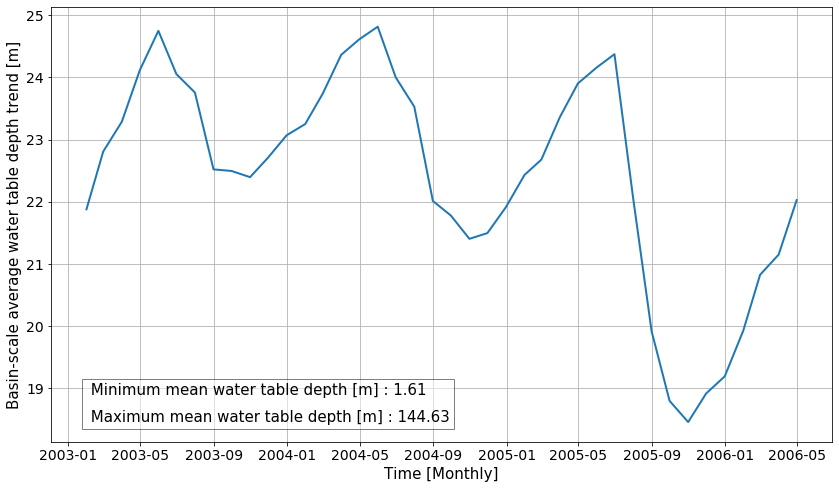

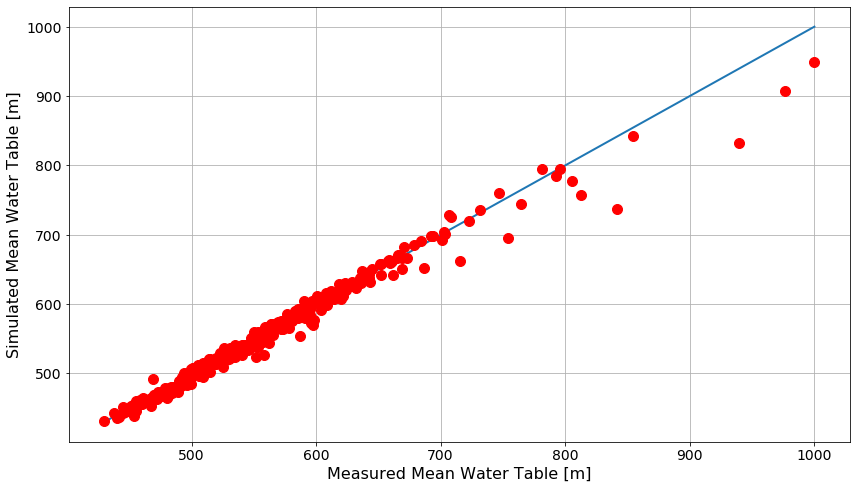

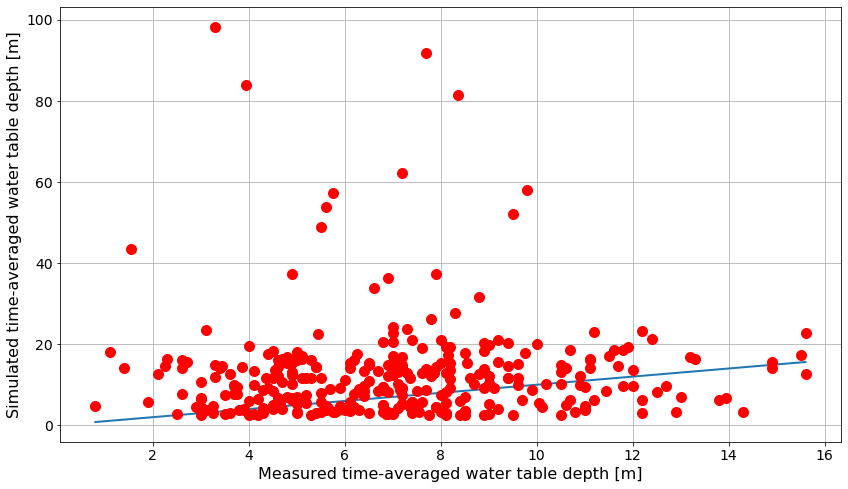

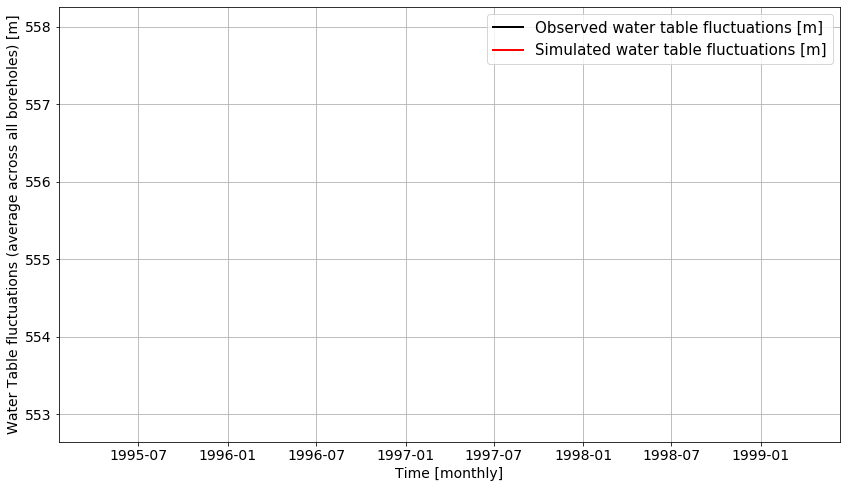

In [4]:
# Plotting .......................................................................................
'''Same plots as in the original notebook... but with pandas'''
borehole = 1  # [1 - 335] Choose a borehole ID if you want to evaluate measured-simulated water tables

## Plot the water balance trend in Groundwater:
fig100 = plt.figure()
plt.plot_date(Time_ModFlowV3, np.nanmean(np.nanmean(Topography_ModFlow - GWTable_ModFlow,1),1), linestyle='solid', marker=None, linewidth=2)
label = ' Minimum mean water table depth [m] : ' + str(round(np.nanmin(MeanWaterTableDepth)*100)/100) + '\n Maximum mean water table depth [m] : ' + str(round(np.nanmax(MeanWaterTableDepth)*100)/100) 
plt.text(Time_ModFlowV3.min(), np.nanmean(np.nanmean(Topography_ModFlow - GWTable_ModFlow,1),1).min(), label, fontsize=15, bbox=dict(facecolor='white', alpha=0.5), linespacing=2)
plt.ylabel('Basin-scale average water table depth trend [m]', fontsize=15)
plt.xlabel('Time [Monthly]', fontsize=15)
plt.xticks(fontsize=14), plt.yticks(fontsize=14), plt.grid()

## Plot time-averaged results for water table comparison ...............
fig101 = plt.figure()
plt.plot([df_stats.MEAN_wt_obs.min(),df_stats.MEAN_wt_obs.max()],[df_stats.MEAN_wt_obs.min(),df_stats.MEAN_wt_obs.max()], linestyle='solid', linewidth=2, marker=None)
plt.plot(df_stats.MEAN_wt_obs, df_stats.MEAN_wt_sim, marker='o', markersize=10, color='r', linestyle='')
# label = ' Pearson correlation coefficient : ' + str(round(df_ave_stats.iloc[0,0]*100)/100) + '\n RMSE [m] : ' + str(round(df_ave_stats.iloc[0,1]*100)/100) + '\n Normalized RMSE: ' + str(round(df_ave_stats.iloc[0,2]*100)/100) 
# plt.text(df_stats.MEAN_wt_obs.min(), df_stats.MEAN_wt_sim.max()-50, label, fontsize=15, bbox=dict(facecolor='white', alpha=0.5), linespacing=2)
plt.xlabel('Measured Mean Water Table [m]', fontsize=16)
plt.ylabel('Simulated Mean Water Table [m]', fontsize= 16)
plt.grid(), plt.xticks(fontsize=14), plt.yticks(fontsize=14)
plt.show()

## Plot time-averaged results for water table depth comparison .........
fig102 = plt.figure()
plt.plot([df_stats.MEAN_wtd_obs.min(),df_stats.MEAN_wtd_obs.max()],[df_stats.MEAN_wtd_obs.min(),df_stats.MEAN_wtd_obs.max()], linestyle='solid', linewidth=2, marker=None)
plt.plot(df_stats.MEAN_wtd_obs, df_stats.MEAN_wtd_sim, marker='o', markersize=10, color='r', linestyle='')
# label = 'Pearson correlation coefficient : ' + str(round(df_ave_stats.iloc[0,3]*100)/100) + '\n RMSE [m] : ' + str(round(df_ave_stats.iloc[0,4]*100)/100) + '\n Normalized RMSE: ' + str(round(df_ave_stats.iloc[0,5]*100)/100) + '\n Mean difference [%] : ' + str(round(df_ave_stats.iloc[0,6]*100)/100) 
# plt.text(df_stats.MEAN_wtd_obs.min(), df_stats.MEAN_wtd_sim.max()-25, label, fontsize=15, bbox=dict(facecolor='white', alpha=0.5), linespacing=2)
plt.xlabel('Measured time-averaged water table depth [m]', fontsize= 16)
plt.ylabel('Simulated time-averaged water table depth [m]', fontsize= 16)
plt.grid(), plt.xticks(fontsize=14), plt.yticks(fontsize=14)
plt.show()

## Plotting timeseries .................................................
plt.figure()
plt.plot_date(df_wt_obs.columns[3:], df_wt_obs.iloc[borehole-1][3:], label='Observed water table fluctuations [m]', linestyle='solid', marker=None, linewidth=2, color='k')
plt.plot_date(df_wt_sim.columns[3:], df_wt_sim.iloc[borehole-1][3:], label='Simulated water table fluctuations [m]', linestyle='solid', marker=None, linewidth=2, color='r')
plt.grid(), plt.legend(fontsize=15), plt.xticks(fontsize=14), plt.yticks(fontsize=14)
plt.xlabel('Time [monthly]', fontsize=14)
plt.ylabel('Water Table fluctuations (average across all boreholes) [m]', fontsize=14)
plt.show()


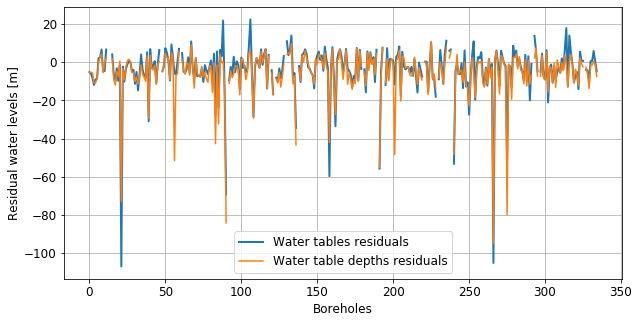

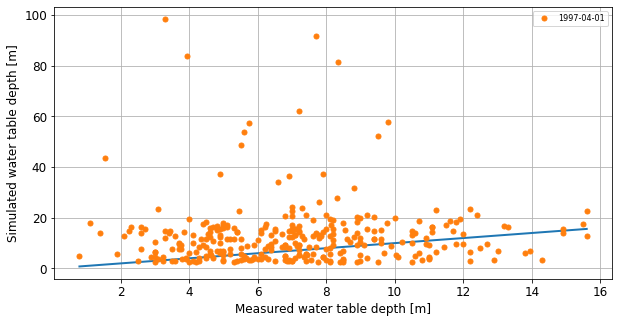

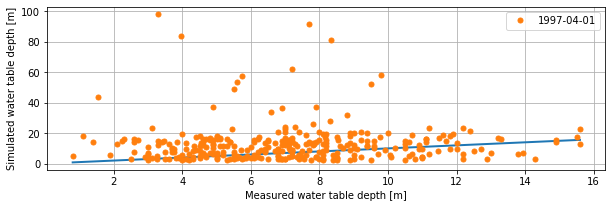

In [5]:
# Further analysis: depending on time ............................................................
## Residual analysis ...................................................
'''Shows a graph with the residuals based o nthe average values per borehole'''
residual_wt  = -df_stats.MEAN_wt_obs + df_stats.MEAN_wt_sim
residual_wtd = df_stats.MEAN_wtd_obs - df_stats.MEAN_wtd_sim

fig103 = plt.figure(figsize=(10,5))
plt.plot(residual_wt, label='Water tables residuals', linestyle='solid', linewidth=2)
plt.plot(residual_wtd, label='Water table depths residuals', linestyle='solid', linewidth=1.5)
plt.xlabel('Boreholes', fontsize=12)
plt.ylabel('Residual water levels [m]', fontsize= 12)
plt.grid(), plt.legend(fontsize=12), plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.show()

## Plotting results for water table depth comparison ...................
plt.figure(figsize=(10,5))
plt.plot([df_wtd_obs.iloc[:,3:].min().min(),df_wtd_obs.iloc[:,3:].max().max()],[df_wtd_obs.iloc[:,3:].min().min(),df_wtd_obs.iloc[:,3:].max().max()], linestyle='solid', linewidth=2, marker=None)
for i in range (np.shape(df_wtd_obs)[1]-3):
    plt.plot(df_wtd_obs.iloc[:,i+3], df_wtd_sim.iloc[:,i+3], label=datetime.date(datetime.fromordinal(int(df_wtd_obs.columns[i+3]))), marker='o', markersize=5, linestyle='')
plt.xlabel('Measured water table depth [m]', fontsize= 12)
plt.ylabel('Simulated water table depth [m]', fontsize= 12)
plt.grid(), plt.legend(fontsize=8), plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.show()

## Plotting results for water table depth comparison per date ..........
'''Shows the measured-simulated graph per recorded date'''
for i in range (np.shape(df_wtd_obs)[1]-3):
    plt.figure(figsize=(10,3))
    plt.plot([df_wtd_obs.iloc[:,i+3].min(),df_wtd_obs.iloc[:,i+3].max()],[df_wtd_obs.iloc[:,i+3].min(),df_wtd_obs.iloc[:,i+3].max()], linestyle='solid', linewidth=2, marker=None)
    plt.plot(df_wtd_obs.iloc[:,i+3], df_wtd_sim.iloc[:,i+3], label=datetime.date(datetime.fromordinal(int(df_wtd_obs.columns[i+3]))), marker='o', markersize=5, linestyle='')
    plt.xlabel('Measured water table depth [m]', fontsize= 10)
    plt.ylabel('Simulated water table depth [m]', fontsize= 10)
    plt.grid(), plt.legend(fontsize=10), plt.xticks(fontsize=10), plt.yticks(fontsize=10)
    plt.show()

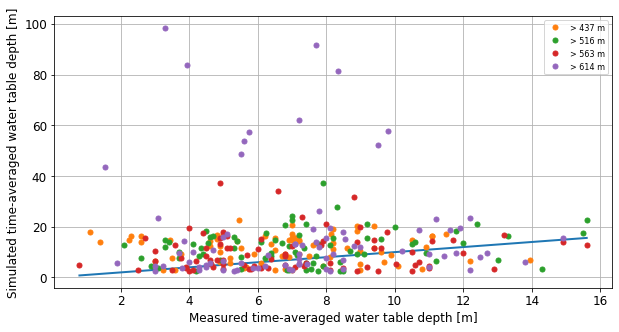

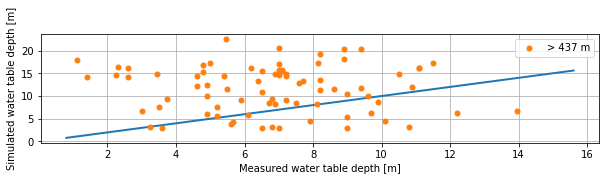

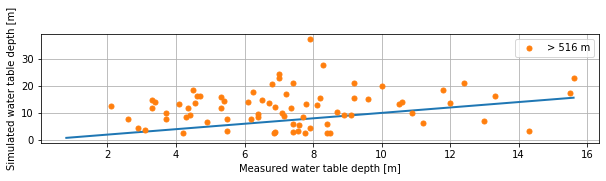

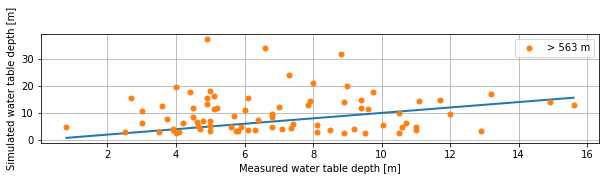

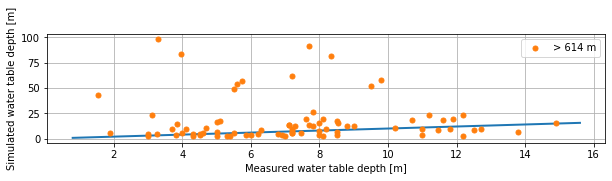

In [6]:
# Further analysis: depending on borehole's altitude .............................................
'''Only specify the number of altitude intervals'''
steps = 4

perc = df_wtd_obs.drop(columns=df_wtd_obs.columns)
for i in range (steps):
    if i==0: perc.loc[df_wtd_obs.Altitude < df_wtd_obs.Altitude.quantile((i+1)/steps), 'perc'] = i+1
    elif i==steps-1: perc.loc[df_wtd_obs.Altitude > df_wtd_obs.Altitude.quantile(i/steps), 'perc'] = i+1
    else: perc.loc[(df_wtd_obs.Altitude > df_wtd_obs.Altitude.quantile(i/steps)) & (df_wtd_obs.Altitude < df_wtd_obs.Altitude.quantile((i+1)/steps)), 'perc'] = i+1

## Plotting results for water table depth comparison ...................
plt.figure(figsize=(10,5))
plt.plot([df_stats.MEAN_wtd_obs.min(),df_stats.MEAN_wtd_obs.max()],[df_stats.MEAN_wtd_obs.min(),df_stats.MEAN_wtd_obs.max()], linestyle='solid', linewidth=2, marker=None)
for i in range (steps):
    plt.plot(df_stats.MEAN_wtd_obs.loc[perc.perc==i+1], df_stats.MEAN_wtd_sim.loc[perc.perc==i+1], label='> '+str(int(df_wtd_obs.Altitude.quantile(i/steps)))+' m', marker='o', markersize=5, linestyle='')
plt.xlabel('Measured time-averaged water table depth [m]', fontsize= 12)
plt.ylabel('Simulated time-averaged water table depth [m]', fontsize= 12)
plt.grid(), plt.legend(fontsize=8), plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.show()

## Plotting results for water table depth comparison ...................
for i in range (steps):
    plt.figure(figsize=(10,2))
    plt.plot([df_stats.MEAN_wtd_obs.min(),df_stats.MEAN_wtd_obs.max()],[df_stats.MEAN_wtd_obs.min(),df_stats.MEAN_wtd_obs.max()], linestyle='solid', linewidth=2, marker=None)
    plt.plot(df_stats.MEAN_wtd_obs.loc[perc.perc==i+1], df_stats.MEAN_wtd_sim.loc[perc.perc==i+1], label='> '+str(int(df_wtd_obs.Altitude.quantile(i/steps)))+' m', marker='o', markersize=5, linestyle='')
    plt.xlabel('Measured water table depth [m]', fontsize= 10)
    plt.ylabel('Simulated water table depth [m]', fontsize= 10)
    plt.grid(), plt.legend(fontsize=10), plt.xticks(fontsize=10), plt.yticks(fontsize=10)
    plt.show()

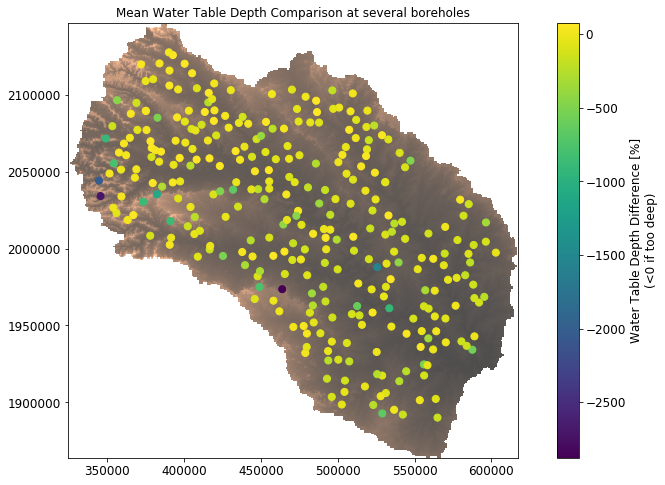

In [7]:
# Further analysis: spatial variation ............................................................
extent = (float(Size[0])-res_ModFlow/2, float(Size[1])+res_ModFlow/2, float(Size[2])+res_ModFlow/2, float(Size[3])-res_ModFlow/2)
Topo = np.copy(Topography_ModFlow)
Topo[np.isnan(MeanWaterTable)] = np.nan

## Plotting spatial discrepancy in water table depth ...................
fig104 = plt.figure()
plt.imshow(Topo, cmap='copper', alpha=0.7, extent=extent, origin='lower')
plt.gca().invert_yaxis()
plt.title('Mean Water Table Depth Comparison at several boreholes', fontsize=12)
plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.scatter(df_wtd_obs.Easting, df_wtd_obs.Northing, c=df_stats.NDIFF_wtd, s=50)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
cb.set_label('Water Table Depth Difference [%]\n(<0 if too deep)', fontsize=12)

In [8]:
# Exporting results ..............................................................................
'''Only add the working folder path'''
working_folder = 'GW_output/'

## Exporting graphs to pdf .............................................
pdf = matplotlib.backends.backend_pdf.PdfPages(path_model_outputs + working_folder + 'Graphs.pdf')
pdf.savefig(fig100)
pdf.savefig(fig101)
pdf.savefig(fig102)
pdf.savefig(fig103)
pdf.savefig(fig104)
pdf.close()

## Exporting tables to excel ...........................................
writer = pandas.ExcelWriter(path_model_outputs + working_folder + '/Tables.xlsx')
df_wt_sim.to_excel(writer,'WT_sim', index=False)
df_wtd_sim.to_excel(writer,'WTd_sim', index=False)
df_stats.to_excel(writer,'Trans_stats', index=False)
df_ave_stats.to_excel(writer,'Ave_stats', index=False)
writer.save()

## Copying useful .nc files ............................................
shutil.copyfile(path_model_outputs+'modflowWaterLevel_monthend.nc', path_model_outputs+working_folder+'modflowWaterLevel_monthend.nc')
shutil.copyfile(path_model_outputs+'modflowtotalSoilThickness_totalend.nc', path_model_outputs+working_folder+'modflowtotalSoilThickness_totalend.nc')

print('Successfully exported')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/CWatM_output/GW_output/Graphs.pdf'